In [1]:
import os, math, sys
sys.path.append("..")
# sys.path.append(r".\a3rdparty\convnets_keras_master")

from keras.layers import Convolution2D, MaxPooling2D, Activation
from keras.models import Model, load_model
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.utils.vis_utils import plot_model
from keras.applications import inception_v3
from keras.applications import vgg16
from keras.applications import vgg19
from keras.applications.imagenet_utils import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
import cv2  # only used for loading the image, you can use anything that returns the image as a np.ndarray

# sys.path.append(r".\a3rdparty\convnets_keras_master\convnetskeras")
# print sys.path
import keras_alexnet

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN 5110)


## Lets see the image!

(32L, 32L, 3L) 32 32 3


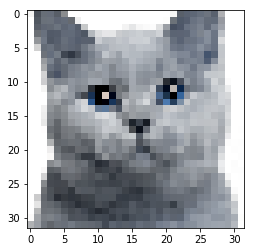

In [2]:
ori_img = cv2.imread(r'C:\DL\image\cat_blue_32.png')
plt.imshow(ori_img)
# what does the image look like?
print ori_img.shape, ori_img.shape[0], ori_img.shape[1], ori_img.shape[2]

In [3]:
img = np.expand_dims(ori_img, axis=-1)
print img.shape, img.shape[0], img.shape[1], img.shape[2]

(32L, 32L, 3L, 1L) 32 32 3


## Load the existed models

In [11]:
weights_file_path = r'C:\DL\keras_test\model\alexnet_weights_th_dim_ordering_th_kernels.h5'
model = load_model(weights_file_path)
print model.summary()

ValueError: No model found in config file.

In [10]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
model_input = model.input
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_name = "conv2d_3"
assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
layer_output = layer_dict[layer_name].output
layer_weights = layer_dict[layer_name].get_weights()
print "layer_output", layer_output
print "layer_weights", layer_weights[0].shape, layer_weights[1].shape, layer_weights[0].shape[3]

layer_output Elemwise{mul,no_inplace}.0
layer_weights (5L, 5L, 16L, 120L) (120L,) 120


In [11]:
input_batch = kvu.pre_process_one_batch(img)

adjust_shape_to_model -> channels_first (1L, 28L, 28L)
input_batch.shape (1L, 1L, 28L, 28L)


In [12]:
output_category = model.predict(input_batch)
print "output_category.shape", output_category.shape
print output_category.argmax(), output_category.argmax(axis=-1)

output_category.shape (1L, 10L)
5 [5]


In [13]:
intermediate_layer_model = Model(inputs=model.input, outputs=layer_output)
output_batch = intermediate_layer_model.predict(input_batch)
print "output_batch.shape", output_batch.shape

output_batch.shape (1L, 120L, 1L, 1L)


In [14]:
get_layer_output = K.function([model_input], [layer_output])
output_batch = get_layer_output([input_batch])[0]
print "output_batch.shape", output_batch.shape

output_batch.shape (1L, 120L, 1L, 1L)


In [15]:
img_features = kvu.post_process_one_batch(output_batch, img)

output_batch.shape (1L, 120L, 1L, 1L)
adjust_shape_to_show -> channels_first (1L, 1L, 120L)
img.shape (1L, 1L, 120L)


Layer Weights: 0 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


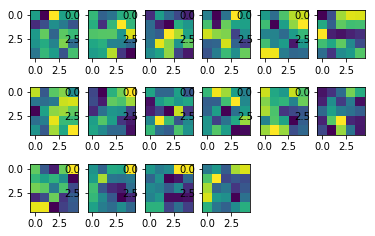

Layer Weights: 1 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


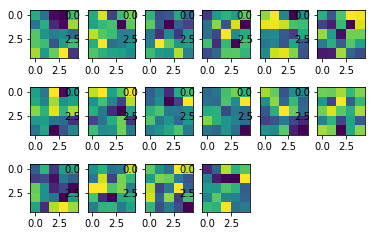

Layer Weights: 2 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


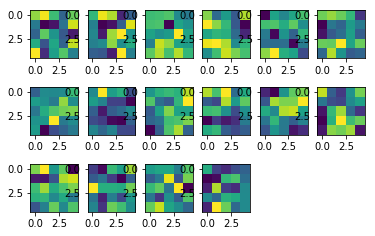

Layer Weights: 3 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


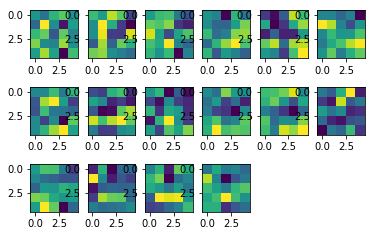

Layer Weights: 4 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


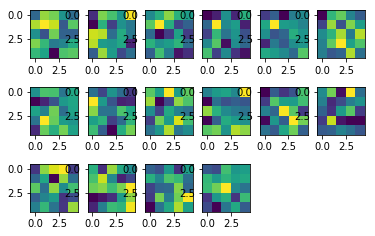

Layer Weights: 5 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


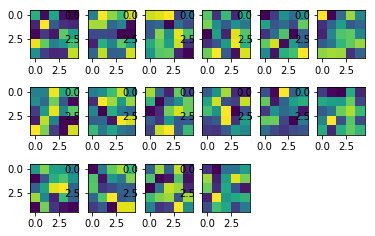

Layer Weights: 6 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


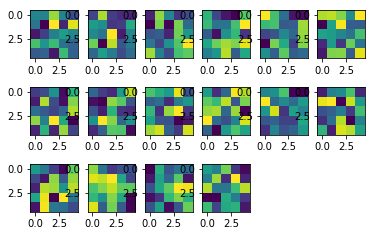

Layer Weights: 7 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


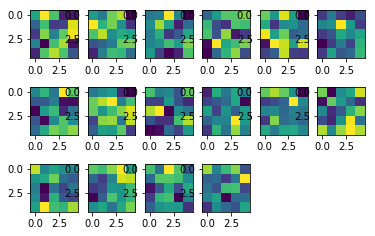

Layer Weights: 8 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


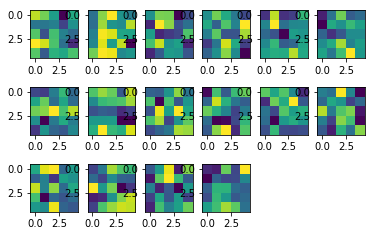

Layer Weights: 9 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


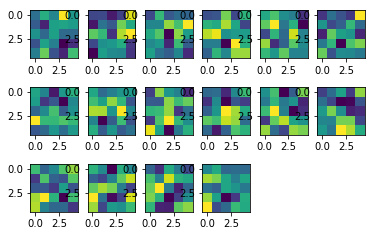

Layer Weights: 10 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


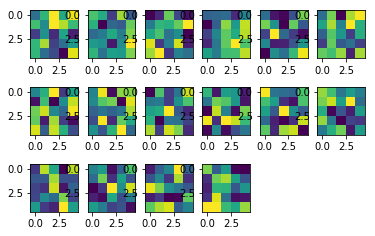

Layer Weights: 11 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


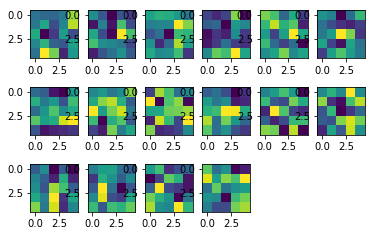

Layer Weights: 12 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


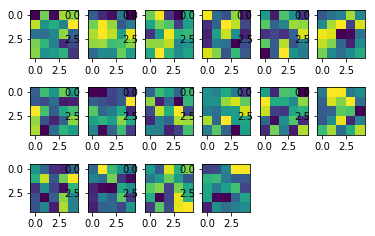

Layer Weights: 13 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


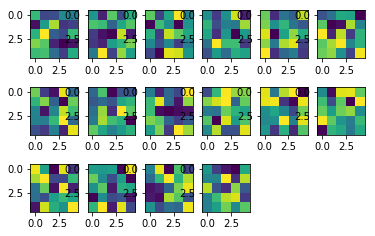

Layer Weights: 14 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


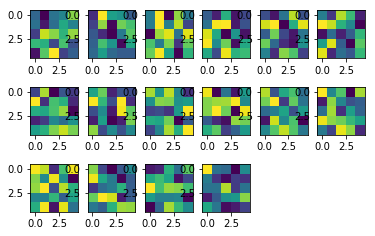

Layer Weights: 15 (5L, 5L, 16L)
img_data.shape (5L, 5L, 16L) 3


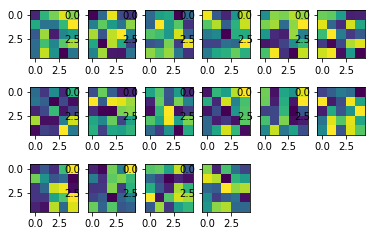

In [18]:
kvu.visualize_layer_weights(layer_weights)

img_data.shape (1L, 1L, 120L) 3


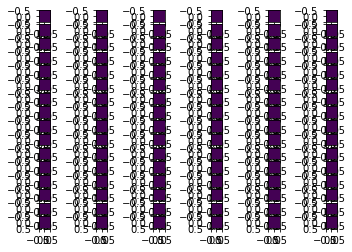

In [19]:
kvu.visualize_img(img_features)